In [1]:
from pathlib import Path
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import pandas as pd

import sys
sys.path.append("/home/tommy/neuralhydrology")
from scripts.read_nh_results import (
    get_test_filepath,
    get_all_station_ds,
    calculate_all_error_metrics,
    get_ensemble_path,
)

from scripts.read_model import (get_model, _load_weights)
from scripts.read_nh_results import (read_multi_experiment_results, calculate_member_errors)
from neuralhydrology.utils.config import Config

%load_ext autoreload
%autoreload 2

In [2]:
data_dir = Path("/datadrive/data")
run_dir = data_dir / "runs/ensemble_NO_EVAP/lstm_ensemble1_NO_EVAP_1606_014459"
out_dir = run_dir / "cell_states"

In [3]:
import geopandas as gpd
from scripts.geospatial import initialise_gb_spatial_plot, load_latlon_points
from mpl_toolkits.axes_grid1 import make_axes_locatable

st_data_dir = Path("/home/tommy/spatio_temporal/data")
points = load_latlon_points(st_data_dir)
static = xr.open_dataset(st_data_dir / "camels_static.nc")

In [4]:
# load config
cfg = Config(run_dir / "config.yml")
cfg.run_dir = run_dir

cfg.dynamic_inputs

['precipitation', 'temperature']

# Probe Targets

In [16]:
# SNOW + SM
era5filepath = (data_dir / "camels_basin_ERA5Land_sm.nc")
era5_sm = xr.open_dataset(era5filepath).drop("spatial_ref")

from scripts.cell_state.normalize import normalize_2d_dataset

if not isinstance(era5_sm, xr.Dataset):
    era5_sm = era5_sm.to_dataset()

for var in era5_sm.data_vars:
    era5_sm[var] = normalize_2d_dataset(era5_sm, variable_str=var, per_basin=False)

# Get cell state data

In [9]:
from scripts.cell_state.extract_cell_state import get_cell_states

out_dir = run_dir / "cell_states"

if not out_dir.exists():
    out_dir.mkdir(parents=True, exist_ok=True)

if not (out_dir / "cell_states.nc").exists():
    cn = get_cell_states(cfg, run_dir)
    cn.to_netcdf(out_dir / "cell_states.nc")
else:
    cn = xr.open_dataset(out_dir / "cell_states.nc")

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",
Extracting cell state for basin:   0%|          | 0/669 [00:00<?, ?it/s]

Using the model weights from /datadrive/data/runs/ensemble_NO_EVAP/lstm_ensemble1_NO_EVAP_1606_014459/model_epoch030.pt


Extracting cell state for basin:   0%|          | 1/669 [00:00<09:25,  1.18it/s]/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",
Extracting cell state for basin:   0%|          | 2/669 [00:01<05:53,  1.89it/s]/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",
Extracting cell state for basin:   0%|          | 3/669 [00:01<04:43,  2.35it/s]/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the futu

In [14]:
from scripts.cell_state.cell_state_dataset import dataset_dimensions_to_variable

# New data
station_dim = "station_id"
time_dim = "date"
# normalize ???
mean_ = cn.mean(dim=[station_dim, time_dim])
std_ = cn.std(dim=[station_dim, time_dim])
norm_cs_data = (cn - mean_) / std_
# or per station-dimension

cs = dataset_dimensions_to_variable(
    ds=norm_cs_data, 
    variable="c_n",
    dimension_to_convert_to_variable_dim="dimension",
    time_dim="date",
).rename({"date": "time"})
cs["station_id"] = cs["station_id"].astype(int)

# Create Probe Samples

In [22]:
from collections import defaultdict 
from scripts.cell_state.timeseries_dataset import TimeSeriesDataset
from scripts.cell_state.timeseries_dataset import get_data_samples, get_time_basin_aligned_samples, get_time_basin_aligned_dictionary

target_ds = era5_sm
input_ds = cs

train_start_date: pd.Timestamp = pd.to_datetime("1998-01-01")
train_end_date: pd.Timestamp = pd.to_datetime("2006-09-30")
test_start_date: pd.Timestamp = pd.to_datetime("2006-10-01")
test_end_date: pd.Timestamp =  pd.to_datetime("2009-10-01")
seq_length = 1
basin_dim = "station_id"
time_dim = "time"
input_variables = [f"dim{i}" for i in np.arange(64)]

# train test split
target_data = target_ds.sel(time=slice(train_start_date, train_end_date))
input_data = input_ds.sel(time=slice(train_start_date, train_end_date))

test_target_data = target_ds.sel(time=slice(test_start_date, test_end_date))
test_input_data = input_ds.sel(time=slice(test_start_date, test_end_date))


all_train_test = defaultdict(dict)
for target_var in target_data.data_vars:
    print(f"** STARTING {target_var} **")
    train_dataset = TimeSeriesDataset(
        input_data=input_data,
        target_data=target_data,
        target_variable=target_var,
        input_variables=input_variables,
        seq_length=seq_length,
        basin_dim=basin_dim,
        time_dim=time_dim,
        desc="Creating Train Samples",
    )

    train = get_time_basin_aligned_dictionary(train_dataset)

    test_dataset = TimeSeriesDataset(
        input_data=test_input_data,
        target_data=test_target_data,
        target_variable=target_var,
        input_variables=input_variables,
        seq_length=seq_length,
        basin_dim=basin_dim,
        time_dim=time_dim,
        desc="Creating Test Samples",
    )

    test = get_time_basin_aligned_dictionary(test_dataset)
    
    all_train_test[target_var]["train"] = train
    all_train_test[target_var]["test"] = test

** STARTING swvl1 **


Extracting Data: 100%|██████████| 8322/8322 [01:01<00:00, 134.61it/s]


Merging and reshaping arrays


Extracting Data: 100%|██████████| 2142/2142 [00:15<00:00, 139.09it/s]


Merging and reshaping arrays
** STARTING swvl2 **


Extracting Data: 100%|██████████| 8322/8322 [00:59<00:00, 139.42it/s]


Merging and reshaping arrays


Extracting Data: 100%|██████████| 2142/2142 [00:15<00:00, 135.65it/s]


Merging and reshaping arrays
** STARTING swvl3 **


Extracting Data: 100%|██████████| 8322/8322 [01:01<00:00, 134.85it/s]


Merging and reshaping arrays


Extracting Data: 100%|██████████| 2142/2142 [00:15<00:00, 136.63it/s]


Merging and reshaping arrays
** STARTING swvl4 **


Extracting Data: 100%|██████████| 8322/8322 [01:03<00:00, 131.44it/s]


Merging and reshaping arrays


Extracting Data: 100%|██████████| 2142/2142 [00:15<00:00, 137.60it/s]


Merging and reshaping arrays
** STARTING sd **


Extracting Data: 100%|██████████| 8322/8322 [01:00<00:00, 138.09it/s]


Merging and reshaping arrays


Extracting Data: 100%|██████████| 2142/2142 [00:15<00:00, 135.07it/s]


Merging and reshaping arrays


In [24]:
# fit and predict all linear probes
from scripts.cell_state.sklearn_models import (
    init_linear_model,
    evaluate,
    create_analysis_dataset,
    fit_and_predict,
)

all_models_preds = defaultdict(dict)
target_vars = [v for v in target_data.data_vars]

for target_var in target_vars:
    print(f"** {target_var} **")
    model, preds, errors = fit_and_predict(all_train_test[target_var]["train"], all_train_test[target_var]["test"], random_seed=100)
    all_models_preds[target_var]["model"] = model
    all_models_preds[target_var]["preds"] = preds
    all_models_preds[target_var]["errors"] = errors

** swvl1 **
-- Epoch 1
Norm: 0.83, NNZs: 47, Bias: 0.019285, T: 1917358, Avg. loss: 0.039443
Total training time: 1.30 seconds.
-- Epoch 2
Norm: 0.83, NNZs: 48, Bias: 0.019991, T: 3834716, Avg. loss: 0.039365
Total training time: 2.73 seconds.
-- Epoch 3
Norm: 0.83, NNZs: 48, Bias: 0.016303, T: 5752074, Avg. loss: 0.039360
Total training time: 4.16 seconds.
-- Epoch 4
Norm: 0.82, NNZs: 48, Bias: 0.024110, T: 7669432, Avg. loss: 0.039360
Total training time: 5.57 seconds.
Convergence after 4 epochs took 5.72 seconds


Calculating Errors: 100%|██████████| 667/667 [00:07<00:00, 86.12it/s, 106001]


** swvl2 **
-- Epoch 1
Norm: 0.87, NNZs: 46, Bias: -0.076945, T: 1917358, Avg. loss: 0.040819
Total training time: 1.32 seconds.
-- Epoch 2
Norm: 0.87, NNZs: 46, Bias: -0.075892, T: 3834716, Avg. loss: 0.040736
Total training time: 2.79 seconds.
-- Epoch 3
Norm: 0.87, NNZs: 46, Bias: -0.081818, T: 5752074, Avg. loss: 0.040731
Total training time: 4.24 seconds.
-- Epoch 4
Norm: 0.87, NNZs: 46, Bias: -0.075113, T: 7669432, Avg. loss: 0.040732
Total training time: 5.69 seconds.
Convergence after 4 epochs took 5.83 seconds


Calculating Errors: 100%|██████████| 667/667 [00:07<00:00, 84.92it/s, 106001]


** swvl3 **
-- Epoch 1
Norm: 0.82, NNZs: 42, Bias: 0.030938, T: 1917358, Avg. loss: 0.036865
Total training time: 1.37 seconds.
-- Epoch 2
Norm: 0.82, NNZs: 42, Bias: 0.030335, T: 3834716, Avg. loss: 0.036797
Total training time: 2.88 seconds.
-- Epoch 3
Norm: 0.82, NNZs: 43, Bias: 0.025847, T: 5752074, Avg. loss: 0.036792
Total training time: 4.37 seconds.
-- Epoch 4
Norm: 0.82, NNZs: 43, Bias: 0.031109, T: 7669432, Avg. loss: 0.036793
Total training time: 5.86 seconds.
Convergence after 4 epochs took 6.01 seconds


Calculating Errors: 100%|██████████| 667/667 [00:07<00:00, 86.18it/s, 106001]


** swvl4 **
-- Epoch 1
Norm: 0.79, NNZs: 42, Bias: -0.009502, T: 1917358, Avg. loss: 0.037926
Total training time: 1.34 seconds.
-- Epoch 2
Norm: 0.79, NNZs: 42, Bias: -0.009286, T: 3834716, Avg. loss: 0.037863
Total training time: 2.84 seconds.
-- Epoch 3
Norm: 0.79, NNZs: 42, Bias: -0.011609, T: 5752074, Avg. loss: 0.037861
Total training time: 4.34 seconds.
-- Epoch 4
Norm: 0.79, NNZs: 42, Bias: -0.010387, T: 7669432, Avg. loss: 0.037859
Total training time: 5.83 seconds.
Convergence after 4 epochs took 5.98 seconds


Calculating Errors: 100%|██████████| 667/667 [00:07<00:00, 86.45it/s, 106001]


** sd **
-- Epoch 1
Norm: 0.23, NNZs: 17, Bias: -0.124663, T: 1917358, Avg. loss: 0.004804
Total training time: 1.65 seconds.
-- Epoch 2
Norm: 0.24, NNZs: 21, Bias: -0.123715, T: 3834716, Avg. loss: 0.004800
Total training time: 3.44 seconds.
-- Epoch 3
Norm: 0.24, NNZs: 20, Bias: -0.123437, T: 5752074, Avg. loss: 0.004798
Total training time: 5.25 seconds.
-- Epoch 4
Norm: 0.24, NNZs: 18, Bias: -0.123668, T: 7669432, Avg. loss: 0.004798
Total training time: 7.03 seconds.
Convergence after 4 epochs took 7.18 seconds


Calculating Errors: 100%|██████████| 667/667 [00:07<00:00, 85.80it/s, 106001]


# Explore Linear Probes

In [ ]:
N = 1
pixels = np.random.choice(p.station_id.values, N, replace=False)


for px in pixels:
    f, axs = plt.subplots(3, 2, figsize=(12, 4*1.5), sharex=True)
    for ix, target_var in enumerate(target_vars):
        ax = axs[np.unravel_index(ix, (n_plots, 2))]
        preds = all_models_preds[target_var]["preds"]
        data = preds.sel(station_id=px, time=time)

    #     f, ax = plt.subplots(figsize=(12, 4))
        ax.plot(data.time, data.obs, color="k", ls="--", alpha=0.3)
        ax.plot(data.time, data.sim, color=f"C{ix}", ls="-", alpha=0.6, label=f"{target_var}")
        ax.legend()
        sns.despine()

In [ ]:
f, ax = plt.subplots(figsize=(12, 4))

colors = sns.color_palette("viridis", n_colors=len(target_vars))
for ix, target_var in enumerate(target_vars):
    errors = all_models_preds[target_var]["errors"]
    nse = errors["NSE"]

    ax.hist(nse.where(nse > -1, -1), bins=100, density=True, label=f"{target_var}: {nse.median().values:.3f}", alpha=0.6, color=colors[ix]);
    ax.axvline(nse.median(), color=colors[ix], ls="--", alpha=0.5)
    

ax.set_xlim(-1, 1)
ax.legend()
sns.despine()

In [ ]:
from scripts.cell_state.analysis import get_model_weights, plot_weights

n_plots = len(target_vars)
f, axs = plt.subplots(n_plots, 1, figsize=(12, 2*n_plots))

for ix, target_var in enumerate(target_vars):
    model = all_models_preds[target_var]["model"]
    ax = axs[ix]
    w, b = get_model_weights(model)
    plot_weights(np.abs(w), kwargs={"vmin": 0.0, "vmax": 0.3}, ax=ax, cbar=False)
    ax.set_title(f"Target: {target_var}")
plt.tight_layout()

# Create forcing data (simulate all temps above 4degC)

In [5]:
from tqdm import tqdm

# dd / "attributes"


def get_basin(file_path: Path) -> int:
    return int(file_path.name.split("timeseries_")[-1].split("_")[0])


def read_single_camelsgb_file(file_path: Path) -> pd.DataFrame:
    df = pd.read_csv(file_path, sep=',', header=0, dtype={'date': str})
    df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")
    df["basin"] = get_basin(file_path)
    df = df.set_index(["date", "basin"])
    
    return df


def load_camelsgb_xr(data_dir: Path) -> xr.Dataset:
    assert (data_dir / "timeseries").exists(), f"Expect to find timeseries folder at {data_dir.as_posix()}"
    dynamic_files = list((data_dir / "timeseries").iterdir())
    pbar = tqdm(dynamic_files, desc="Loading Basins:")
    xrs = []
    for fp in pbar:
        xrs.append(read_single_camelsgb_file(fp).to_xarray())
    
    print("Concatenating all files")
    ds = xr.concat(xrs, dim="basin")
    return ds

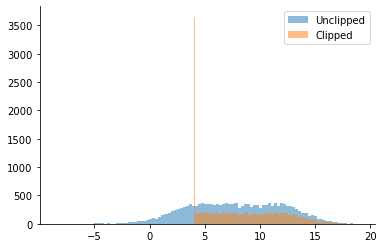

In [7]:
import pickle

additional_feature_files = (cfg.data_dir / "additional_feature_files.pkl")

if not additional_feature_files.exists():
    # load in the camelsGB timeseries
    ds = load_camelsgb_xr(cfg.data_dir)
    
    # create clipped temperature dict
    variable = "temperature"
    pickle_dict = {}
    pbar = tqdm(ds.basin.values, f"Clipping {variable}")
    for basin in pbar:
        pbar.set_postfix_str(f"{basin}")
        basin_clipped = clipped.sel(basin=basin).to_dataframe().drop("basin", axis=1)
        basin_clipped = basin_clipped.rename({"temperature": "temperature_clipped"}, axis=1)
        pickle_dict[str(basin)] = basin_clipped
        
    # write to pickle
    with additional_feature_files.open("wb") as fp:
        pickle.dump(pickle_dict, fp)
        
d = pickle.load(additional_feature_files.open("rb"))
assert "temperature_clipped" in d["10002"].columns

In [9]:
scaler_file = cfg.run_dir / "train_data" / "train_data_scaler.p"
with scaler_file.open('rb') as fp:
    scaler = pickle.load(fp)

if "temperature_clipped" not in scaler["xarray_feature_scale"].data_vars:
    # copy new scale/center
    scaler["xarray_feature_scale"]["temperature_clipped"] = scaler["xarray_feature_scale"]["temperature"]
    scaler["xarray_feature_center"]["temperature_clipped"] = scaler["xarray_feature_center"]["temperature"]

    with scaler_file.open('wb') as fp:
        pickle.dump(scaler, fp)
        
scaler["xarray_feature_scale"].data_vars

Data variables:
    discharge_spec       float64 3.587
    precipitation        float64 5.929
    temperature          float64 5.156
    temperature_clipped  float64 5.156

In [25]:
cfg.test_start_date

Timestamp('1998-01-01 00:00:00')